In [76]:
%matplotlib inline
##from skimage import data, io, filters
import os
import numpy as np
from PIL import Image
import matplotlib
from matplotlib import pyplot,pylab
plt = pyplot
import scipy
from __future__ import division
import seaborn as sns
sns.set_style('white')
import string
import pandas as pd
import json
import pymongo as pm
import analysis_helpers as h
reload(h)

<module 'analysis_helpers' from 'analysis_helpers.pyc'>

#### setup and establish access to the database

In [90]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['3dObjects']
coll = db['shapenet_chairs_speaker_eval']

In [91]:
## get records
recs = coll.find({'$and': [{'iterationName':'pilot0'},{'timestamp':{'$gt':1507674252874}}]}).sort('gameID')
print '{} records in the database.'.format(recs.count())
print '{} unique workers participated.'.format(len(recs.distinct('wID')))

2832 records in the database.
46 unique workers participated.


#### loop through games and build up group data csv

In [92]:
# get list of games
recs = coll.find({'$and': [{'iterationName':'pilot0'},{'timestamp':{'$gt':1507674252874}}]}).sort('gameID')
games = recs.distinct('gameID')

In [79]:
# extract relevant info from db
trialNum = []
condition = []
correct = []
family = []
gameID = []
response = []
rt = []
target = []
distractor1 = []
distractor2 = []

for i,this_game in enumerate(games):    
    print 'Analyzing {} of {} games ... '.format(i,len(games))
    game_recs = coll.find({'$and': [{'iterationName':'pilot0'},{'timestamp':{'$gt':1507674252874}},\
                                   {'gameID':this_game}]}).sort('timestamp')
    
    for trial in game_recs:
        trialNum.append(trial['trialNum'])
        condition.append(trial['condition'])
        correct.append(trial['correct'])
        family.append(trial['family'])
        gameID.append(trial['gameID'])
        response.append(trial['response'].split('_')[0])
        rt.append(trial['rt'])
        target.append([i.split('_')[0] for i in recs[0]['choices'] if i[-6:]=='target'][0])
        distractor1.append([i.split('_')[0] for i in recs[0]['choices'] if i[-11:]=='distractor1'][0])
        distractor2.append([i.split('_')[0] for i in recs[0]['choices'] if i[-11:]=='distractor2'][0])
            

Analyzing 0 of 51 games ... 
Analyzing 1 of 51 games ... 
Analyzing 2 of 51 games ... 
Analyzing 3 of 51 games ... 
Analyzing 4 of 51 games ... 
Analyzing 5 of 51 games ... 
Analyzing 6 of 51 games ... 
Analyzing 7 of 51 games ... 
Analyzing 8 of 51 games ... 
Analyzing 9 of 51 games ... 
Analyzing 10 of 51 games ... 
Analyzing 11 of 51 games ... 
Analyzing 12 of 51 games ... 
Analyzing 13 of 51 games ... 
Analyzing 14 of 51 games ... 
Analyzing 15 of 51 games ... 
Analyzing 16 of 51 games ... 
Analyzing 17 of 51 games ... 
Analyzing 18 of 51 games ... 
Analyzing 19 of 51 games ... 
Analyzing 20 of 51 games ... 
Analyzing 21 of 51 games ... 
Analyzing 22 of 51 games ... 
Analyzing 23 of 51 games ... 
Analyzing 24 of 51 games ... 
Analyzing 25 of 51 games ... 
Analyzing 26 of 51 games ... 
Analyzing 27 of 51 games ... 
Analyzing 28 of 51 games ... 
Analyzing 29 of 51 games ... 
Analyzing 30 of 51 games ... 
Analyzing 31 of 51 games ... 
Analyzing 32 of 51 games ... 
Analyzing 33 of 51 g

In [93]:
# make dataframe
X = pd.DataFrame([trialNum,condition,correct,family,gameID,response,rt,target,distractor1,distractor2])
X = X.transpose()
X.columns = ['trialNum','condition','correct','family','gameID','response','rt','target','distractor1','distractor2']
X = h.convert_numeric(X,'correct')
X = h.convert_numeric(X,'rt')

In [94]:
# save out to csv
X.to_csv('./shapenet_chairs_speaker_eval_group_data.csv')

In [95]:
X.groupby('condition')['correct'].mean()

condition
literal      0.678598
pragmatic    0.765684
Name: correct, dtype: float64

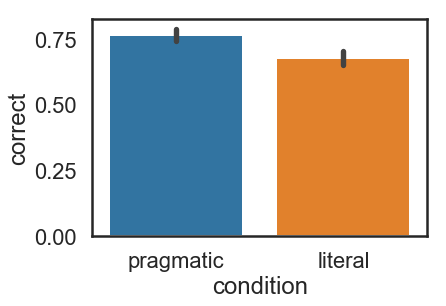

In [96]:
sns.barplot(data=X,
            x='condition',
            y='correct')